# CNN Facial Recognition

## 1. Introduction
Hello! My selfgiven name is the Stats Whisper and I'm back with another Data Science topic that is one of the hottest things in research now: Deep Learning. Even if you lend a very small ear to what is going on in the scientific community, you have probably heard of Deep Learning. It is the backbone of some of the coolest things today like: self-driving cars, facial-recongition, virtual digital assistants and [accurately estimating how a human on the other side of a wall is standing/sitting/walking just from perturbations in Wifi signals caused by that human](http://rfpose.csail.mit.edu/) (don't know what good that is for but hey).


Believe or not, neural networks have been around for a while but the slashed costs of computing power paired with the increased computing capacity are the impetus behind the eponential growth of the field. 

With the expantion of the field, grew different kinds of neural networks for different purposes. 
Today, we will be focusing on a particular type of neural network called a convolution neural network (CNN for short). Research has found these models to be excellent when it comes to image recognition. And image recognition we shall. 

## 2. Convolution Neural Network

Okay, so before we dive into what exactly a convolution neural network is let us strip it down to its essence, just a plain and simple vanilla neural network. Like the depths of the universe, you can go as far, wide and deep into this topic and you'll probably never get to the bottom of it because of the presence of a very active area of research that is pushing the field even further. 

So what exactly is a neural network? Well, it's actually pretty simple: a function. A function that can be very complex but a function nevertheless. 

At its most basic core, a neural network has 3 parts:
 - input layer
 - hidden layer
 - output layer

As the name suggests, the input layer is where the data is feed into the network. The mysterious hidden layer is where all the action is happening and output layer is the result you wish to acquire. 

In relation to a function, take the ubiquitous function of simple line found in every Algebra class: y = mx+b. The x in this case is the input layer. The m and b are hidden layer and the y is the output layer. 

Easy right?

A convolution neural network does the exact same thing by using an image as input, crunches some numbers then does a prediction as an output.

There is a great amount of content out there that goes into good detail and further explains how the mechanics of a convolution neural network work. It can get very mathematical and technical really quick so you can easily lose an audience. But if you are really interested to go further, I found [this video](https://www.youtube.com/watch?v=aircAruvnKk) to be a lifesaver for my Big Data class while I was learning neural networks in grad school.



## 3. Application

If you ever wondered how in the world your new Iphone has the capacity to determine whether or not it's your face or someone else's face with amazing accuracy to unlock your phone using Face ID, well you have just witnessed the power of neural networks first hand. Apple trained the neural networks using billions of images then took the result and installed it into your iphone. Pretty cool, huh?

Since neural networks are great at determining who's face that image belongs to, what if we could weild this technology to find my celebrity doppleganger. 

In my much younger (and more atheltic days), some of friends would say I looked like soccer superstar Neymar while others would disagree. Well, let's use a neural network to settle the debate for us. Let's feed it a bunch of pictures from world class athletes and have the CNN decide who I resemble to most. 

To make this worthwhile, let's use 7 different athletes and see what the model returns. If I indeed look like Neymar then when I feed it an image of myself then it will output a prediction of Neymar. Sounds like a plan, right? All right, let's roll. 


### 3.1 Loading the Data

Okay so first let's load the data. We'll be using Google's Colab product to leverage the powerfull GPU available, slashing runtimes instead waiting forever for it to run locally on my MacBook.

This data was acquired from Google Images after being cropped and reshaped. The data includes 30 images for Neymar, Leonel Messi, Cristiano Ronaldo, Kevin Durant, Odel Beckham, Steph Curry, Arron Rodgers.

The data was split 80/20 for training and validation purposes. 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
K.set_image_dim_ordering('th')
from time import time
batch_size = 64

train_datagen = ImageDataGenerator(data_format="channels_last")

test_datagen = ImageDataGenerator(data_format="channels_last")

train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/My Drive/CNN/data/train',  # this is the target directory
        target_size=(197, 197),  # all images will be resized to 250x250
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        '/content/gdrive/My Drive/CNN/data/validation',
        target_size=(197, 197),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')

label_map = validation_generator.class_indices

### 3.2 Transfer Learning

Instead of creating a CNN from scratch and having to use valuable time and resources training/testing different models, what we can do instead is use a model that has already been trained then slightly customize it to fit our objectives. The formal term for this technique is called "transfer learning". 

Transfer learning is great because you can take neural networks and their respective weights painstakingly developed by the pros then reuse those models for other purposes. 

While TensorFlow is the gold standard for neural networks I perfer to use Keras because of the way it simplyfies long cumbersome TensorFlow code into a few simple lines of code and, more importantly, Keras comes pre-trained models available for execute transfer learning. 

Today, we'll be using a CNN developed by researchers at Cornell University called [MobileNetV2](https://arxiv.org/abs/1801.04381). While most of the available models have compariable accuracy rates, this model is "lightweight" with it's fewer total parameters in the model and thus faster to train. 

In [0]:
#importing the relevant libraries and modules for CNN
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from keras import backend as K
from keras.callbacks import TensorBoard
import keras

input_tensor = Input(shape=(197, 197, 3))

# create the base pre-trained model
base_model = MobileNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)


# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
# since we have 7 classes, we need a final layer that predicts 7 classes. 
predictions = Dense(7, activation='softmax')(x)

custom_model = Model(inputs=base_model.input, outputs=predictions)

# compile the model
custom_model.compile(optimizer=keras.optimizers.Adam(lr=0.00009), loss='categorical_crossentropy',metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="/content/gdrive/My Drive/CNN/tensorBoard/".format(time()), write_images=True, write_graph=True)

custom_model.fit_generator(
        train_generator,
        steps_per_epoch=10,
        callbacks = [tensorboard],
        epochs=15,
        validation_data=validation_generator,
        validation_steps=10,
        verbose=1)

custom_model.save("/content/gdrive/My Drive/CNN/custom_model_weights.h5")

with open('/content/gdrive/My Drive/CNN/custom_model_architecture.json', 'w') as f:
    f.write(custom_model.to_json())

You'll notice that the accuracy of the model rapidly increases after each iteration. That's because the model is leveraging the features it previously learned and putting them to use to make sense of the images that are being feed. You are witnessing the power of transfer learning in action.



### 3.3 CNN Applied



So now with a fully trained model at hand, we can use deep learning to help us in our quest for truth. If Neymar is indeed my doppleganger then when I feed the model some images of myself, then it should output a higher probabilitity than the rest of the classes. The converse would imply that we'll have to look elsewhere for my doppleganger. 

In [145]:
#need to hide this cell or run 1 code cell then delete this one 

from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
K.set_image_dim_ordering('th')
from time import time
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import preprocess_input
import numpy as np
from keras.models import model_from_json
batch_size = 64

#Loading model and associated weights already compiled. 
# Model reconstruction from JSON file
with open('custom_model_architecture.json', 'r') as f:
    custom_model = model_from_json(f.read())
    print("Finished Loading Model")
    
# Load weights into the new model
custom_model.load_weights('custom_model_weights.h5')
print("Loaded associated weights for model")

test_datagen = ImageDataGenerator(data_format="channels_last")

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(197, 197),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='categorical')

label_map = validation_generator.class_indices

Finished Loading Model
Loaded associated weights for model
Found 42 images belonging to 7 classes.


      Neymar 41.63 %
     Ronaldo 17.9 %
       Messi 16.09 %
     Rodgers 13.66 %
     Beckham 6.95 %
      Irving 2.39 %
       Curry 1.37 %



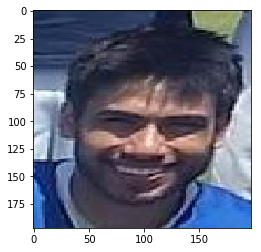

In [152]:
#To make the evaluation of the images simplier, a function was created to display the results
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

    
def model_output(prediction,label_map):    
    results = {list(label_map.keys())[i]:prediction[0][i] for i in range(len(prediction[0]))}
    for key in sorted(results, key=lambda k: results[k],reverse=True):
        print('%12s'%key,round(results[key]*100,2),"%")
    print()

def predict_image(image_path,model,label_map):
    img = image.load_img(image_path, target_size=(197, 197))
    imshow(img, interpolation='none')
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.reshape(1,197,197,3)
    x = preprocess_input(x)
    probabilities = model.predict(x)
    Image(image_path)
    model_output(probabilities,label_map)


predict_image("data/julio1.jpg",custom_model,label_map)

      Neymar 38.91 %
     Ronaldo 26.25 %
       Messi 14.74 %
     Rodgers 12.49 %
     Beckham 4.07 %
      Irving 2.07 %
       Curry 1.46 %



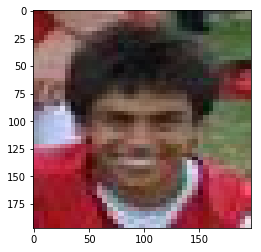

In [154]:
predict_image("data/julio2.jpg",custom_model,label_map)

     Ronaldo 32.5 %
     Rodgers 23.36 %
      Neymar 20.84 %
       Messi 15.39 %
     Beckham 4.93 %
      Irving 1.76 %
       Curry 1.22 %



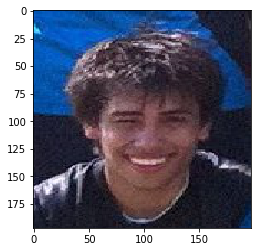

In [156]:
predict_image("data/julio3.jpg",custom_model,label_map)

      Neymar 47.19 %
     Ronaldo 18.63 %
       Messi 15.06 %
     Rodgers 13.06 %
     Beckham 3.14 %
      Irving 1.96 %
       Curry 0.97 %



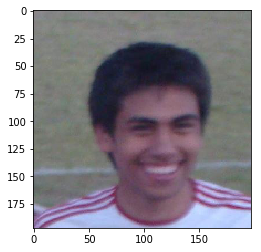

In [159]:
predict_image("data/julio4.jpg",custom_model,label_map)

## 4. Conclusion

And there you have it folks. For 3 of 4 images, the model outputted a higher probability that the image was Neymar while only 1 image had Ronaldo as the highest probability for that image. Pro-Neymar camps seems to come out on top for now but this raise a good point. 

While the model correctly classified the images in the valdiation set 88% of the time, it wasn't perfect. A number of factors like image lighting, facial hair/different hairstyle, wearing of hats can impact model accuracy. This highlights the  importance of, not just having a good amount of data, but of having high quality data that has these twists and turns that will provide a more robust model. Generally, neural networks require a large amount of data to work their magic. Luckily, there is something called Data Augmentation that can help in acquiring more data when none is available. The idea is simple: get an image then modify in several different ways to have different variations of that same image. Here's an example: ![basic augmentation](data_augmentation2.png)
At a basic level, you can: flip, crop, scale, translate the images to get "new" images that forces your model to learn the true features of the image. You can go a step further with more advanced data augmentation techniques as seen in this image. 
![advanced augmentation](data_augmentation3.png)